## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
import os
%matplotlib inline

## Helper Functions

In [2]:
def read_img(img_path):
    #reading in an image
    image = mpimg.imread(img_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    return image

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, line_type, color=[0, 255, 127], thickness=31):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Flag for determining whether full line is drawn or line segment
    if line_type == "segments": # then draw line segments
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    elif line_type == "solid": # then draw full line
        # y coordinates for top and bottom of lane lines of interest
        y_max = img.shape[0]
        y_min = int(img.shape[0] * 0.6)
        
        # gathering the x1 coordinates on x-axis for the left line
        left_line_x1_crdnts = []
        # gathering the x2 coordinates on x-axis for the left line
        left_line_x2_crdnts = []
        
        # gathering the x1 coordinates on x-axis for the right line
        right_line_x1_crdnts = []
        # gathering the x2 coordinates on x-axis for the right line
        right_line_x2_crdnts = []
        
        for line in lines:
            for x1,y1,x2,y2 in line:
                # Separate line segments by their slope
                # calculate slope
                m = ((y2-y1)/(x2-x1))
                
                # checking for 0 and continuing to next iteration to avoid divide by 0
                if (x2-x1) == 0:
                    continue
                
                
                # calculate y-intercept
                b = y1-(m*x1)
                
                # checking for 0 and continuing to next iteration to avoid divide by 0
                if m == 0:
                    continue
                
                # Find x coordinates with respect to y_max and y_min
                x1 = (y_max - b)/m
                x2 = (y_min - b)/m
                
                # left_slope (left lane) -y/+x
                if m < 0: 
                    # draw line segment for left_slope
                    #print("Points for left slope")
                    left_line_x1_crdnts.append(x1)
                    left_line_x2_crdnts.append(x2)
                
                # right_slope (right lane) +y/+x
                elif m > 0:
                    # draw line segment for right_slope 
                    #print("Points for right slope")
                    right_line_x1_crdnts.append(x1)
                    right_line_x2_crdnts.append(x2)        
            
        if (len(left_line_x1_crdnts) > 0 and len(left_line_x2_crdnts) > 0):
            #print("Drawing Left Line")
            left_x1_sum = 0
            left_x2_sum = 0
            for left_x1_crdnt, left_x2_crdnt in zip(left_line_x1_crdnts, left_line_x2_crdnts):
                left_x1_sum += left_x1_crdnt # get sum for left line x1 coordinate
                left_x2_sum += left_x2_crdnt # get sum for left line x2 coordinate
            # get average for x1 and x2 coordinates of left line            
            left_line_x1_avg = left_x1_sum / len(left_line_x1_crdnts)
            left_line_x2_avg = left_x2_sum / len(left_line_x2_crdnts)
            # Draw solid line for left lane
            cv2.line(img, (int(left_line_x1_avg), y_max), (int(left_line_x2_avg), y_min), color, thickness)
        if (len(right_line_x1_crdnts) > 0 and len(right_line_x2_crdnts) > 0):
            #print("Drawing Right Line")
            right_x1_sum = 0
            right_x2_sum = 0    
            for right_x1_crdnt, right_x2_crdnt in zip(right_line_x1_crdnts, right_line_x2_crdnts):
                right_x1_sum += right_x1_crdnt # get sum for right line x1 coordinate
                right_x2_sum += right_x2_crdnt # get sum for right line x2 coordinate 
            # get average for x1 and x2 coordinates of right line
            right_line_x1_avg = right_x1_sum / len(right_line_x1_crdnts)
            right_line_x2_avg = right_x2_sum / len(right_line_x2_crdnts)                
            # Draw solid line for right lane                
            cv2.line(img, (int(right_line_x1_avg), y_max), (int(right_line_x2_avg), y_min), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, line_type):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, line_type)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline

## Read Image

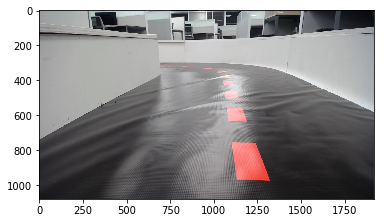

In [3]:
# Take Image
image = mpimg.imread("/home/self-car/Autonomous-Car/application/data/cam_data/1547786906080.jpeg")
plt.imshow(image)

## Copy Image for Color and Region Selection

In [4]:
color_select = np.copy(image)
region_select = np.copy(image)
lane_line_img = np.copy(image)

## Convert RGB Image to HSV Image

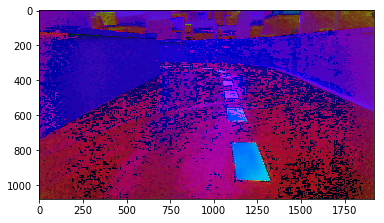

In [5]:
# HSV, 
# Hue range is [0,179], Saturation range is [0,255], Value range is [0,255]
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
plt.imshow(hsv)

## Define Range to Detect RED Color in HSV Image

In [6]:
# Define range of red color in HSV
# lower red (begin and end) threshold
lower_red_begin = np.array([0, 15, 135])
lower_red_end = np.array([10, 255, 255])

# upper red (begin and end) threshold
upper_red_begin = np.array([170, 15, 130])
upper_red_end = np.array([180, 255, 255])

# Threshold the HSV image to get only red colors
lower_threshold_mask1 = cv2.inRange(hsv, lower_red_begin, lower_red_end)
upper_threshold_mask2 = cv2.inRange(hsv, upper_red_begin, upper_red_end)

# Merge the mask and crop the red regions
red_hue_mask_image = cv2.bitwise_or(lower_threshold_mask1, upper_threshold_mask2)

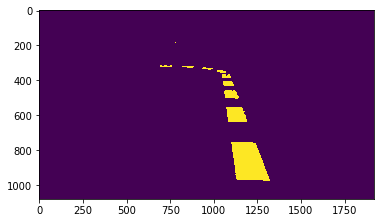

In [7]:
plt.imshow(red_hue_mask_image)

## Apply Region Masking to Original Image

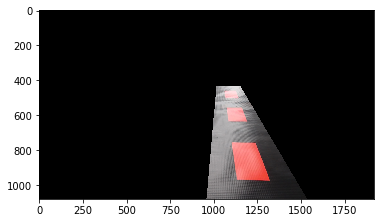

In [8]:
# Region Masking to Original Image
imshape = image.shape
vertices = np.array([[(imshape[1]*0.5,imshape[0]),
                      (imshape[1]*0.53,imshape[0]*0.4),
                      (imshape[1]*0.6,imshape[0]*0.4),
                      (imshape[1]*0.8,imshape[0])]], dtype=np.int32)
region_select = region_of_interest(image, vertices)
plt.imshow(region_select)

## Apply Region Masking to HSV Masked Image

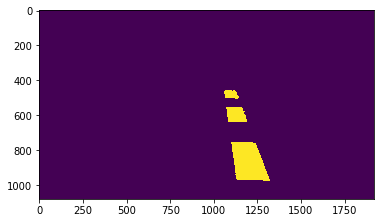

In [9]:
imshape = red_hue_mask_image.shape
vertices = np.array([[(imshape[1]*0.5,imshape[0]),
                      (imshape[1]*0.53,imshape[0]*0.4),
                      (imshape[1]*0.6,imshape[0]*0.4),
                      (imshape[1]*0.8,imshape[0])]], dtype=np.int32)
region_select = region_of_interest(red_hue_mask_image, vertices)
plt.imshow(region_select)

## Apply Hough Transform to HSV Masked Image

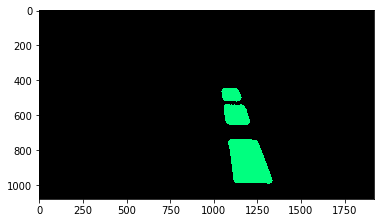

In [10]:
# Set Hough Transform Parameters:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20 # minimum number of votes (intersections in Hough grid cell)
min_line_len = 5 # minimum number of pixels making up a line
max_line_gap = 10 # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # Make a blank the same size as our image to draw on

line_type = "segments"
lane_line_img = hough_lines(region_select, rho, theta, threshold, min_line_len, max_line_gap, line_type)
plt.imshow(lane_line_img)

## Overlay Hough Image onto Original Image

In [11]:
img_with_lanes = weighted_img(image, lane_line_img)

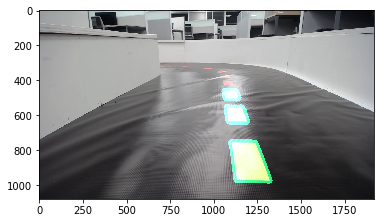

In [12]:
plt.imshow(img_with_lanes)

## Save Overlayed Image with Lane Lines Detected

In [14]:
if not os.path.exists("test_images_output/line_segments/"):
    os.makedirs("test_images_output/line_segments/")
mpimg.imsave("test_images_output/line_segments/" + "cam_track_leftside.jpeg", img_with_lanes)